In [52]:
import pandas as pd 
import torch 
import matplotlib.pyplot as plt
import numpy as np 

Посмотрим на данные значений биткоина с 2010 по 2020

In [53]:
usd_to_btc_df = pd.read_csv('btcusd_full_hour_2020_02_01.csv')
usd_to_btc_df.head()    

,date,time,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol,avg
0,2010-09-24 22:00:00,1285365600,0.0622,0.0622,0.0622,0.0,0.0,0.0622,direct,NaN,0.0622
1,2010-09-24 23:00:00,1285369200,0.0622,0.0622,0.0622,0.0,0.0,0.0622,direct,NaN,0.0622
2,2010-09-25 00:00:00,1285372800,0.0622,0.0622,0.0622,0.0,0.0,0.0622,direct,NaN,0.0622
3,2010-09-25 01:00:00,1285376400,0.0622,0.0622,0.0622,0.0,0.0,0.0622,direct,NaN,0.0622
4,2010-09-25 02:00:00,1285380000,0.0622,0.0622,0.0622,0.0,0.0,0.0622,direct,NaN,0.0622


from  2013-03-01 06:00:00
to  2019-12-29 10:00:00


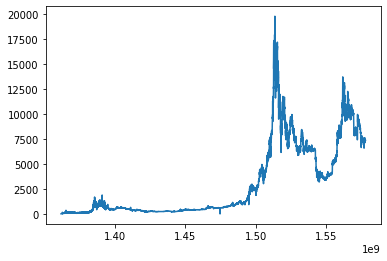

In [54]:
# from 0 to 1
start = int(0.26 * len(usd_to_btc_df['avg']))
stop = int(0.99 * len(usd_to_btc_df['avg']))
plt.plot(usd_to_btc_df['time'][start:stop], usd_to_btc_df['avg'][start:stop])
print("from ",usd_to_btc_df['date'][start])
print("to ",usd_to_btc_df['date'][stop])

Эмпирически выяснили, что вся движуха началась только после примерно 2013-03-01 06:00:00
Остальные данные неинтересны, потому что всем было все равно

#Определим сеть

In [55]:
from torch import nn
class Perceptron1(torch.nn.Module):
    def __init__(self):
        super(Perceptron1, self).__init__()
        self.fc1 = nn.Linear(10, 1000)
        self.act1 = nn.Tanh()
        self.fc2 = nn.Linear(1000, 500)
        self.act2 = nn.Tanh()
        self.fc3 = nn.Linear(500, 250)
        self.act3 = nn.Tanh()
        self.fc4 = nn.Linear(250, 125)
        self.act4 = nn.Tanh()
        self.fc5 = nn.Linear(125, 1)
        self.act5 = nn.Tanh()
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.act3(x)
        x = self.fc4(x)
        x = self.act4(x)
        x = self.fc5(x)
        x = self.act5(x) * 1e5
        return x

class Perceptron2(torch.nn.Module):
    def __init__(self):
        super(Perceptron2, self).__init__()
        self.fc1 = nn.Linear(10, 500)
        self.act1 = nn.Tanh()
        self.fc2 = nn.Linear(500, 1000)
        self.act2 = nn.Tanh()
        self.fc3 = nn.Linear(1000, 2000)
        self.act3 = nn.Tanh()
        self.fc4 = nn.Linear(2000, 1000)
        self.act4 = nn.Tanh()
        self.fc5 = nn.Linear(1000, 800)
        self.act5 = nn.Tanh()
        self.fc6 = nn.Linear(800, 200)
        self.act6 = nn.Tanh()
        self.fc7 = nn.Linear(200, 1)
        self.act7 = nn.Tanh()
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.act3(x)
        x = self.fc4(x)
        x = self.act4(x)
        x = self.fc5(x)
        x = self.act5(x)
        x = self.fc6(x)
        x = self.act6(x)
        x = self.fc7(x)
        x = self.act7(x) * 1e5
        return x

class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        # RNN Layer
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   
        # Fully connected layer
        self.fc1 = nn.Linear(hidden_dim, output_size)
        self.act = nn.Tanh()
        self.fc2 = nn.Linear(output_size, 100)
        self.fc3 = nn.Linear(100, 1250)
        self.fc4 = nn.Linear(1250, 750)
        self.fc5 = nn.Linear(750, 500)
        self.fc6 = nn.Linear(500, 50)
        self.fc7 = nn.Linear(50, 1)
    def forward(self, x):
        
        batch_size = x.size(0)
        x = torch.reshape(x, (x.size(0), 1, x.size(1)))
        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden)
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc1(out)
        out = self.act(out)
        out = self.fc2(out)
        out = self.act(out)
        out = self.fc3(out)
        out = self.act(out)
        out = self.fc4(out)
        out = self.act(out)
        out = self.fc5(out)
        out = self.act(out)
        out = self.fc6(out)
        out = self.act(out)
        out = self.fc7(out)
        out = self.act(out) * 1e5
        return out
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden

Обучение

In [56]:
import time
def generate_batch_data(device, x, y, batch_size):
    dataset = torch.utils.data.TensorDataset(x.to(device), y.to(device))
    loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False)

    for batch, [x_batch, y_batch] in enumerate(loader, 1):
        yield x_batch, y_batch, batch

Сделаем предобработку

x_train  torch.Size([56597, 10])
x_validatation  torch.Size([4092, 10])
y_train  torch.Size([56597])
y_validatation  torch.Size([4092])


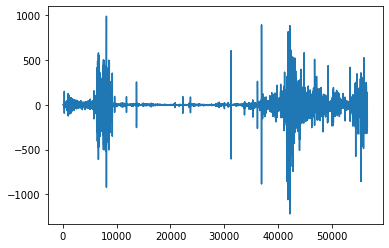

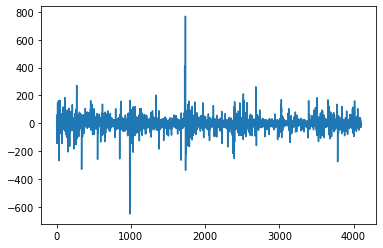

In [57]:

train = usd_to_btc_df['avg'][int(0.26 * len(usd_to_btc_df['avg'])):int(0.95 * len(usd_to_btc_df['avg']))].to_list()
validation = usd_to_btc_df['avg'][int(0.95 * len(usd_to_btc_df['avg'])):].to_list()

def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff


def inverse_difference(inverted, first_value):
    original = [first_value]
    for i, item in enumerate(inverted):
        original.append(original[i] + item)
    return original

inverted_train = difference(train)
inverted_validation = difference(validation)

x_train = [inverted_train[i:i+10] for i in range(len(inverted_train) - 10)]
x_validatation = [inverted_validation[i:i+10] for i in range(len(inverted_validation) - 10)]

y_train = inverted_train[10:]
y_validatation = inverted_validation[10:]

x_train = np.array(x_train)
x_train = torch.from_numpy(x_train).float()
print("x_train ", x_train.size())
x_validatation = np.array(x_validatation)
x_validatation = torch.from_numpy(x_validatation).float()
print("x_validatation ", x_validatation.size())
y_train = np.array(y_train)
y_train = torch.from_numpy(y_train).float()
print("y_train ", y_train.size())
y_validatation = np.array(y_validatation)
y_validatation = torch.from_numpy(y_validatation).float()
print("y_validatation ", y_validatation.size())
plt.plot(range(len(inverted_train)),inverted_train)
plt.show()

plt.plot(range(len(inverted_validation)),inverted_validation)
plt.show()




In [58]:
def train(model, n_epochs, device, x_train, y_train, x_validatation, y_validatation, batch_size, loss_function, optimizer):
    train_losses = []
    validation_losses = []
    model.train()
    for epoch in range(n_epochs):
        start_time = time.time()

        train_loss = 0
        val_loss = 0
        batch = 0
        for x_batch, y_batch, batch in generate_batch_data(device, x_train, y_train, batch_size):
            y_pred = model(x_batch)

            optimizer.zero_grad()
            loss = loss_function(y_pred, y_batch)
            
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= batch
        train_losses.append(train_loss)

        with torch.no_grad():
            for x_val_batch, y_val_batch, n in generate_batch_data(device, x_validatation, y_validatation, batch_size):
                val_loss += loss_function(model(x_val_batch), y_val_batch).item()
            val_loss /= n
            validation_losses.append(val_loss)
        elapsed = time.time() - start_time
        if True:
            print(f"Epoch {str(epoch + 1):>02}"
                    f" Train loss: {train_loss:.4f}."
                    f" Validation loss: {val_loss:.4f}."
                    f" Elapsed time: {elapsed:.2f}s.")
    return model, train_losses, validation_losses
    


/Users/petrlarockin/Library/Python/3.8/lib/python/site-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([800])) that is different to the input size (torch.Size([800, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/Users/petrlarockin/Library/Python/3.8/lib/python/site-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([597])) that is different to the input size (torch.Size([597, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/Users/petrlarockin/Library/Python/3.8/lib/python/site-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcas

Epoch 01 Train loss: 732.1575. Validation loss: 26.1050. Elapsed time: 7.80s.
Epoch 02 Train loss: 226.2729. Validation loss: 429.6638. Elapsed time: 8.29s.
Epoch 03 Train loss: 302.9260. Validation loss: 38.4106. Elapsed time: 8.67s.
Epoch 04 Train loss: 235.9160. Validation loss: 30.1671. Elapsed time: 7.97s.
Epoch 05 Train loss: 135.6696. Validation loss: 78.2627. Elapsed time: 7.86s.
Epoch 06 Train loss: 153.2760. Validation loss: 143.3414. Elapsed time: 8.28s.
Epoch 07 Train loss: 119.3222. Validation loss: 26.9291. Elapsed time: 7.96s.
Epoch 08 Train loss: 155.0593. Validation loss: 29.7241. Elapsed time: 8.57s.
Epoch 09 Train loss: 73.6540. Validation loss: 35.9966. Elapsed time: 7.84s.
Epoch 10 Train loss: 113.9428. Validation loss: 68.1833. Elapsed time: 7.81s.
Epoch 11 Train loss: 60.3931. Validation loss: 28.6947. Elapsed time: 7.68s.
Epoch 12 Train loss: 122.7403. Validation loss: 152.0358. Elapsed time: 7.85s.
Epoch 13 Train loss: 75.0087. Validation loss: 87.3363. Elapsed

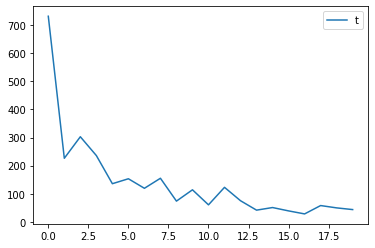

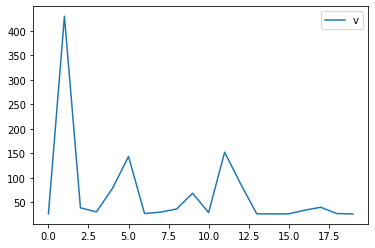

In [59]:
model1 = Model(10, 50, 10, 30)
device = torch.device('cpu')
batch_size= 800
n_epochs= 20
optimizer = torch.optim.Adam(model1.parameters(), lr=0.0001)
loss_function = torch.nn.L1Loss()
done_model1, train_loss1, val_loss1 = train(model1, n_epochs, device, x_train, y_train, x_validatation, y_validatation, batch_size, loss_function, optimizer)
plt.plot(range(len(train_loss1)),train_loss1)
plt.legend("train_loss")
plt.show()
plt.plot(range(len(val_loss1)),val_loss1)
plt.legend("val_loss")
plt.show()

Epoch 01 Train loss: 790.2975. Validation loss: 217.2222. Elapsed time: 22.21s.
Epoch 02 Train loss: 130.6133. Validation loss: 114.3918. Elapsed time: 21.65s.
Epoch 03 Train loss: 91.2618. Validation loss: 65.1111. Elapsed time: 21.56s.
Epoch 04 Train loss: 82.5762. Validation loss: 48.5626. Elapsed time: 21.48s.
Epoch 05 Train loss: 61.9285. Validation loss: 56.4379. Elapsed time: 21.56s.
Epoch 06 Train loss: 68.1969. Validation loss: 44.2120. Elapsed time: 21.66s.
Epoch 07 Train loss: 73.5500. Validation loss: 47.9556. Elapsed time: 21.53s.
Epoch 08 Train loss: 88.5666. Validation loss: 44.7950. Elapsed time: 21.60s.
Epoch 09 Train loss: 47.4792. Validation loss: 39.0071. Elapsed time: 21.45s.
Epoch 10 Train loss: 40.1703. Validation loss: 37.7161. Elapsed time: 21.62s.
Epoch 11 Train loss: 53.8754. Validation loss: 39.8040. Elapsed time: 21.53s.
Epoch 12 Train loss: 59.4973. Validation loss: 37.2127. Elapsed time: 21.46s.
Epoch 13 Train loss: 41.8375. Validation loss: 33.2158. Elap

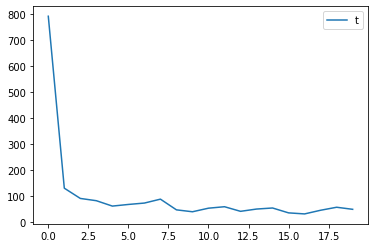

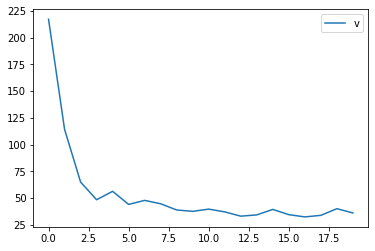

In [60]:
model2 = Perceptron2()
device = torch.device('cpu')
batch_size= 800
n_epochs= 20
optimizer = torch.optim.Adam(model2.parameters(), lr=0.0001)
loss_function = torch.nn.L1Loss()
done_model2, train_loss2, val_loss2 = train(model2, n_epochs, device, x_train, y_train, x_validatation, y_validatation, batch_size, loss_function, optimizer)
plt.plot(range(len(train_loss2)),train_loss2)
plt.legend("train_loss")
plt.show()
plt.plot(range(len(val_loss2)),val_loss2)
plt.legend("val_loss")
plt.show()


Epoch 01 Train loss: 3069.0090. Validation loss: 1094.1781. Elapsed time: 3.73s.
Epoch 02 Train loss: 558.6488. Validation loss: 422.9210. Elapsed time: 3.63s.
Epoch 03 Train loss: 270.8792. Validation loss: 306.5969. Elapsed time: 3.73s.
Epoch 04 Train loss: 202.8975. Validation loss: 224.5983. Elapsed time: 3.62s.
Epoch 05 Train loss: 157.9238. Validation loss: 208.2359. Elapsed time: 3.73s.
Epoch 06 Train loss: 149.5118. Validation loss: 160.9561. Elapsed time: 3.72s.
Epoch 07 Train loss: 143.8545. Validation loss: 153.3596. Elapsed time: 3.59s.
Epoch 08 Train loss: 130.7836. Validation loss: 152.9945. Elapsed time: 3.72s.
Epoch 09 Train loss: 102.8666. Validation loss: 122.4293. Elapsed time: 3.63s.
Epoch 10 Train loss: 101.1587. Validation loss: 116.6672. Elapsed time: 3.70s.
Epoch 11 Train loss: 96.8502. Validation loss: 101.1634. Elapsed time: 3.70s.
Epoch 12 Train loss: 82.8346. Validation loss: 104.5034. Elapsed time: 3.62s.
Epoch 13 Train loss: 76.6682. Validation loss: 98.67

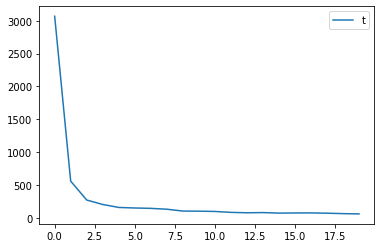

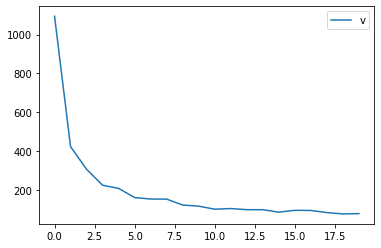

In [61]:
model3 = Perceptron1()
device = torch.device('cpu')
batch_size= 800
n_epochs= 20
optimizer = torch.optim.Adam(model3.parameters(), lr=0.0001)
loss_function = torch.nn.L1Loss()
done_model3, train_loss3, val_loss3 = train(model3, n_epochs, device, x_train, y_train, x_validatation, y_validatation, batch_size, loss_function, optimizer)
plt.plot(range(len(train_loss3)),train_loss3)
plt.legend("train_loss")
plt.show()
plt.plot(range(len(val_loss3)),val_loss3)
plt.legend("val_loss")
plt.show()

Давайте посмотрим как можно использовать эту модель

In [62]:
usd_to_btc_Binance = pd.read_csv('Binance_BTCUSDT_1h.csv')
usd_to_btc_Binance = usd_to_btc_Binance.iloc[::-1] 
usd_to_btc_Binance.head()


,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount
42391,1.502942e+09,2017-08-17 04-AM,BTC/USDT,16199.91,16199.91,4261.32,4308.83,44.5100,190952.85,NaN
42390,1.502946e+09,2017-08-17 05-AM,BTC/USDT,4308.83,4328.69,4291.37,4315.32,23.2300,100304.82,NaN
42389,1.502950e+09,2017-08-17 06-AM,BTC/USDT,4315.32,4345.45,4309.37,4324.35,7.2300,31282.31,NaN
42388,1.502953e+09,2017-08-17 07-AM,BTC/USDT,4324.35,4349.99,4287.41,4349.99,4.4400,19241.06,NaN
42387,1.502957e+09,2017-08-17 08-AM,BTC/USDT,4349.99,4377.85,4333.32,4360.69,0.9499,4139.70,NaN


Предсказание на 500 временных единиц

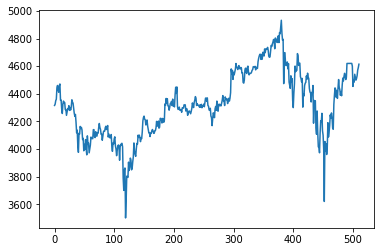

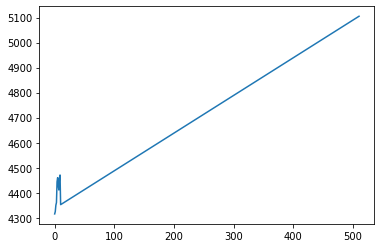

##########################


In [63]:
def check(new_model):
    future_len = 500
    data = usd_to_btc_Binance['open'].to_list()[2:]
    difference_data = difference(data)
    x_test = difference_data[:10]

    for i in range(future_len):
        new_diff = new_model(torch.tensor([x_test[i:i+10]])).item()
        x_test.append(new_diff)
        
    result = inverse_difference(x_test, data[0])

    plt.plot(range(len(result)),data[:len(result)])
    plt.show()
    plt.plot(range(len(result)), result)
    plt.show()
    print("##########################")

check(done_model1)

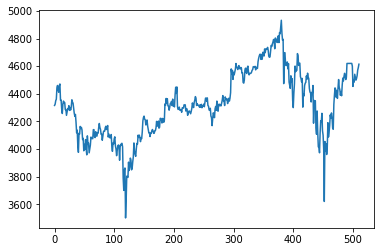

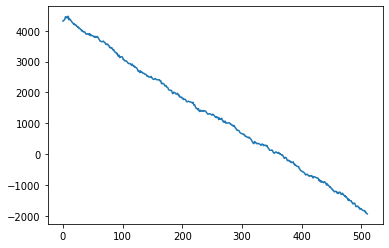

##########################


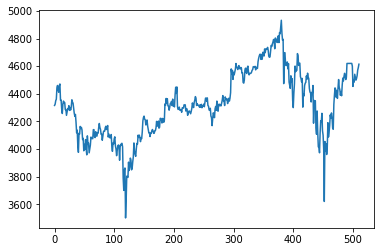

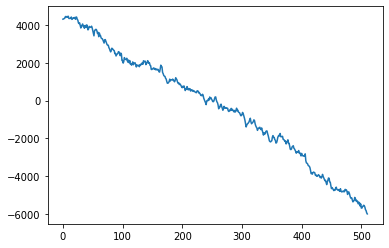

##########################


In [64]:
def check(new_model):
    future_len = 500
    data = usd_to_btc_Binance['open'].to_list()[2:]
    difference_data = difference(data)
    x_test = difference_data[:10]

    for i in range(future_len):
        new_diff = new_model(torch.tensor(x_test[i:i+10])).item()
        x_test.append(new_diff)
        
    result = inverse_difference(x_test, data[0])

    plt.plot(range(len(result)),data[:len(result)])
    plt.show()
    plt.plot(range(len(result)), result)
    plt.show()
    print("##########################")

check(done_model2)

check(done_model3)

Система принятия решения

In [65]:
from torch import nn
class Classifier(torch.nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(10, 500)
        self.act1 = nn.Sigmoid()
        self.fc2 = nn.Linear(500, 1000)
        self.act2 = nn.Sigmoid()
        self.fc3 = nn.Linear(1000, 500)
        self.act3 = nn.Sigmoid()
        self.fc4 = nn.Linear(500, 250)
        self.act4 = nn.Sigmoid()
        self.fc5 = nn.Linear(250, 1)
        self.act5 = nn.Sigmoid()
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.act3(x)
        x = self.fc4(x)
        x = self.act4(x)
        x = self.fc5(x)
        x = self.act5(x)
        return x
classifier = Classifier()
device = torch.device('cpu')
batch_size= 800
n_epochs= 20
train_losses = []
validation_losses = []
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.0001)
loss_function = torch.nn.L1Loss()

y_train[y_train > 0] = 1
y_train[y_train <= 0] = 0

y_validatation[y_validatation > 0] = 1
y_validatation[y_validatation <= 0] = 0
y_validatation
classificator, _, _ = train(classifier, n_epochs, device, x_train, y_train, x_validatation, y_validatation, batch_size, loss_function, optimizer)

TypeError: super(type, obj): obj must be an instance or subtype of type

In [ ]:
def get_recomendation(classificator, first_ten, thresh):
    first_ten = torch.tensor(first_ten)
    ans = classificator(first_ten)
    return ans >= thresh